In [1]:
import xarray as xr
import numpy as np

# Charger le fichier NetCDF
file_path = "/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/6902802_Sprof.nc"
ds = xr.open_dataset(file_path)

In [ ]:
variables_to_interpolate = [
    var for var in ds.data_vars
    if "N_LEVELS" in ds[var].dims and not var.endswith("QC")
]
print(variables_to_interpolate)

# Définition de la grille régulière en pression
pressure_grid = np.arange(1, 6001, 1)

# Fonction d'interpolation pour une variable donnée
def interpolate_variable_on_pressure_grid(pres, variable):
    """
    Interpole une variable donnée sur une grille régulière de pression.
    Fonction conçue pour être utilisée avec `xarray.apply_ufunc`.
    """
    valid_mask = ~np.isnan(pres) & ~np.isnan(variable)  # Supprimer les NaN
    pres_valid = pres[valid_mask]
    variable_valid = variable[valid_mask]
    
    if len(pres_valid) > 1:
        return np.interp(pressure_grid, pres_valid, variable_valid, left=np.nan, right=np.nan)
    else:
        return np.full_like(pressure_grid, np.nan)


# Appliquer l'interpolation pour chaque variable
interpolated_variables = {}
for var in variables_to_interpolate:
    interpolated_variables[var] = xr.apply_ufunc(
        interpolate_variable_on_pressure_grid,  # Fonction d'interpolation
        ds["PRES"],  # Grille de pression
        ds[var],  # Variable à interpoler
        input_core_dims=[["N_LEVELS"], ["N_LEVELS"]],  # Dimensions d'entrée
        output_core_dims=[["pressure"]],  # Dimension de sortie
        vectorize=True,  # Vectorisation implicite
        dask="parallelized",  # Support de parallélisation avec Dask
        output_dtypes=[float],  # Type des données de sortie
    )

In [4]:
interpolated_variables

{'PRES': <xarray.DataArray 'PRES' (N_PROF: 159, pressure: 6000)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [ 1.,  2.,  3., ..., nan, nan, nan],
        [ 1.,  2.,  3., ..., nan, nan, nan],
        ...,
        [ 1.,  2.,  3., ..., nan, nan, nan],
        [ 1.,  2.,  3., ..., nan, nan, nan],
        [ 1.,  2.,  3., ..., nan, nan, nan]])
 Dimensions without coordinates: N_PROF, pressure,
 'PRES_ADJUSTED': <xarray.DataArray (N_PROF: 159, pressure: 6000)>
 array([[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 1.00000036e+00,  2.00000025e+00,  3.00000000e+00, ...,
                     nan,             nan,             nan],
        [ 1.00000070e+00,  2.00000037e+00,  3.00000014e+00, ...,
                     nan,             nan,             nan],
        ...,
        [-9.22337204e+18, -9.22337204e+18, -9.22337204e+18, ...,
         -9.22337204e+18, -9.22337204e+18, -9.22337204e+18],
        [-9.2233

In [5]:
# Ajouter les coordonnées et créer un nouveau dataset interpolé
ds_interpolated = xr.Dataset(
    {
        var: data.assign_coords(pressure=pressure_grid)
        for var, data in interpolated_variables.items()
    },
#    coords={
#        "profile": ds["profile"],
#        "pressure": pressure_grid,
#    },
)

In [6]:
ds

<xarray.Dataset>
Dimensions:                       (N_PROF: 159, N_PARAM: 4, N_CALIB: 2,
                                   N_LEVELS: 2005)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/58)
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    ...                            ...
    DOXY                          (N_PROF, N_LEVELS) float32 303.2 nan ... nan
    DOXY_QC                       (N_PROF, N_LEVELS) object ...
    DOXY_dPRES                    (N_PROF, N_LEVELS) float32 0.0 nan ... nan nan
    DOXY_ADJUSTED                 (N_PROF, N_LEVELS) float32 nan nan ... nan nan
    DOXY_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    DOXY_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 nan nan ... nan nan
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2023-03-20T16:17:04Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.15 (version 09.06.2022 for ARGO_simplified_profile)

In [7]:
ds_interpolated

<xarray.Dataset>
Dimensions:              (pressure: 6000, N_PROF: 159)
Coordinates:
  * pressure             (pressure) int64 1 2 3 4 5 ... 5996 5997 5998 5999 6000
Dimensions without coordinates: N_PROF
Data variables: (12/15)
    PRES                 (N_PROF, pressure) float64 nan nan nan ... nan nan nan
    PRES_ADJUSTED        (N_PROF, pressure) float64 nan nan ... -9.223e+18
    PRES_ADJUSTED_ERROR  (N_PROF, pressure) float64 nan nan ... -9.223e+18
    TEMP                 (N_PROF, pressure) float64 nan nan nan ... nan nan nan
    TEMP_dPRES           (N_PROF, pressure) float64 nan nan nan ... nan nan nan
    TEMP_ADJUSTED        (N_PROF, pressure) float64 nan nan ... -9.223e+18
    ...                   ...
    PSAL_ADJUSTED        (N_PROF, pressure) float64 nan nan ... -9.223e+18
    PSAL_ADJUSTED_ERROR  (N_PROF, pressure) float64 nan nan ... -9.223e+18
    DOXY                 (N_PROF, pressure) float64 nan nan nan ... nan nan nan
    DOXY_dPRES           (N_PROF, pressure) float64 nan nan nan ... nan nan nan
    DOXY_ADJUSTED        (N_PROF, pressure) float64 -9.223e+18 ... nan
    DOXY_ADJUSTED_ERROR  (N_PROF, pressure) float64 -9.223e+18 ... nan

In [8]:
ds_interpolated['PRES']

<xarray.DataArray 'PRES' (N_PROF: 159, pressure: 6000)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [ 1.,  2.,  3., ..., nan, nan, nan],
       [ 1.,  2.,  3., ..., nan, nan, nan],
       ...,
       [ 1.,  2.,  3., ..., nan, nan, nan],
       [ 1.,  2.,  3., ..., nan, nan, nan],
       [ 1.,  2.,  3., ..., nan, nan, nan]])
Coordinates:
  * pressure  (pressure) int64 1 2 3 4 5 6 7 ... 5995 5996 5997 5998 5999 6000
Dimensions without coordinates: N_PROF

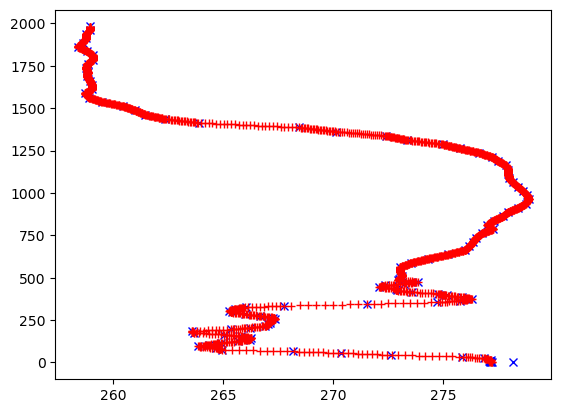

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(ds['DOXY'][10,:],ds['PRES'][10,:],'xb')
plt.plot(ds_interpolated['DOXY'][10,:],ds_interpolated['PRES'][10,:],'+r')
plt.show()